In [1]:
import os
from dotenv import load_dotenv
load_dotenv()  #load all the environment variables

True

In [2]:
os.environ['GEMINI_API_KEY']=os.getenv("GEMINI_API_KEY")

In [3]:
MODEL_NAME='text-embedding-004'

In [4]:
from google import genai
client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])

In [5]:
result = client.models.embed_content(
        model=MODEL_NAME,
        contents="What is the meaning of life?")
result

EmbedContentResponse(embeddings=[ContentEmbedding(values=[-0.010632273, 0.019375853, 0.020965198, 0.0007706437, -0.061464068, 0.014739741, -0.0022759985, 0.013184195, 0.014464715, 0.022593116, 0.02184836, -0.059616957, 0.06032222, -0.047657482, 0.017848385, -0.10987464, -0.0598155, -0.00479664, -0.043298274, -0.05090505, 0.029398112, 0.011642447, 0.04183789, -0.017999396, 0.011026355, 0.049722955, 0.012025892, 0.007331535, 0.01967245, -0.0025621902, 0.028765293, 0.0068937168, 0.0029231338, -0.0002095079, 0.032031864, 0.02518659, -0.032855466, 0.00758291, -0.00011585959, -0.034515556, -0.066151336, 0.03191643, -0.026680378, 0.017334407, -0.025778342, -0.008119435, -0.002431255, -0.009850676, -0.030725427, 0.08225489, 0.036220998, -0.011677602, -0.048477963, 0.026030278, 0.0027632737, -0.036962725, -0.051528536, -0.027265795, 0.04703419, -0.03285586, -0.015140722, -0.003516825, -0.006665491, -0.024252947, -0.031371485, 0.056986455, -0.02846856, 0.009047717, -0.021733612, 0.01993043, -0.0

In [6]:
# Extract the embedding vector
embedding = result.embeddings[0].values
embedding[:10] # print first 10

[-0.010632273,
 0.019375853,
 0.020965198,
 0.0007706437,
 -0.061464068,
 0.014739741,
 -0.0022759985,
 0.013184195,
 0.014464715,
 0.022593116]

In [7]:
len(embedding)

768

## Batch encode content

In [8]:
result = client.models.embed_content(
    model=MODEL_NAME,
    contents=[
      'What is the meaning of life?',
      'How much wood would a woodchuck chuck?',
      'How does the brain work?'])

for embedding in result.embeddings:
    # Print just a part of the embedding to keep the output manageable
  print(str(embedding)[:50], '... TRIMMED]')
     

values=[-0.010632273, 0.019375853, 0.020965198, 0. ... TRIMMED]
values=[0.018468002, 0.0054281265, -0.017658807, 0 ... TRIMMED]
values=[0.058089074, 0.020941732, -0.10872878, -0. ... TRIMMED]


## Truncating embeddings
- specify truncated dimension using output_dimensionality

In [9]:
text=["Hello world"]
# Not truncated
result1 = client.models.embed_content(
    model=MODEL_NAME,
    contents=text)


# Truncated
from google.genai import types

result2 = client.models.embed_content(
    model=MODEL_NAME,
    contents=text,
    config=types.EmbedContentConfig(output_dimensionality=10))

embeddings = []

[embedding1] = result1.embeddings
[embedding2] = result2.embeddings

embeddings.append(embedding1)
embeddings.append(embedding2)

for embedding in embeddings:
    # Print just a part of the embedding to keep the output manageable
  print(str(embedding)[:100], '... TRIMMED]')
  print(f'(Embedding size={len(embedding.values)})')

values=[0.013168517, -0.00871193, -0.046782672, 0.00069969177, -0.009518872, -0.008720178, 0.0601035 ... TRIMMED]
(Embedding size=768)
values=[0.013168517, -0.00871193, -0.046782672, 0.00069969177, -0.009518872, -0.008720178, 0.0601035 ... TRIMMED]
(Embedding size=10)


## Specify task_type
The task_type changes how the model embeds text, tailoring it for specific use cases. The embedding vector will have the same length, but its semantic structure changes, optimized for the specified task.

### Task Types for `text-embedding-004`

| `task_type`             | Description                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| retrieval_document | Embeds **documents** to be retrieved later using a query embedding.         |
| retrieval_query    | Embeds **queries** used to search among previously embedded documents.      |
| semantic_similarity | Embeds items for **semantic similarity** comparisons (e.g., sentence ≈ sentence). |
| classification     | Embeds text for **classification** tasks.                                   |
| clustering       | Embeds text so similar examples group well in **vector space**.              |
| unspecified/ omit  | Default, **general-purpose** embedding. May perform okay across multiple tasks. |


In [10]:
for task in ["retrieval_query", "retrieval_document", "semantic_similarity", "classification", "clustering"]:
    result = client.models.embed_content(
        model="text-embedding-004",
        contents=["Cats chase mice."],
        config={"task_type": task}
    )
    print(f"{task}: {str(result.embeddings[0].values[:5])}...")  # Show first 5 dims


retrieval_query: [-0.02422752, 0.0084479675, 0.06396049, 0.01470588, -0.016860466]...
retrieval_document: [-0.04154495, 0.022686243, 0.0035096072, -0.021847429, -0.0059164832]...
semantic_similarity: [-0.066067874, 0.0059835487, 0.050161198, 0.019868124, -0.0011644209]...
classification: [-0.0369032, 0.01488158, 0.027654625, 0.027929306, -0.03332667]...
clustering: [-0.02422752, 0.0084479675, 0.06396049, 0.01470588, -0.016860466]...


### Compare cross-sentence similarity (e.g., different texts under same task_type)

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

text = "The quick brown fox jumps over the lazy dog."

# Task types to compare
task_types = [
    "retrieval_document",
    "retrieval_query",
    "semantic_similarity",
    "classification",
    "clustering",
    "unspecified"  # You could also use `None` here
]


# Embed text with each task type
embeddings = {}
for task in task_types:
    config = {"task_type": task} if task != "unspecified" else {}
    response = client.models.embed_content(
        model="text-embedding-004",
        contents=text,
        config=config
    )
    
    embeddings[task] = np.array(response.embeddings[0].values)

# Compute cosine similarity matrix
print("\nCosine similarity between embeddings for different task types:\n")
task_count = len(task_types)
similarity_matrix = np.zeros((task_count, task_count))

for i, task1 in enumerate(task_types):
    for j, task2 in enumerate(task_types):
        sim = cosine_similarity(embeddings[task1].reshape(1, -1), embeddings[task2].reshape(1, -1))
        similarity_matrix[i, j] = sim[0, 0]

# Display as a formatted table
import pandas as pd

df = pd.DataFrame(similarity_matrix, index=task_types, columns=task_types)
print(df.round(3))


Cosine similarity between embeddings for different task types:

                     retrieval_document  retrieval_query  semantic_similarity  \
retrieval_document                1.000            0.809                0.679   
retrieval_query                   0.809            1.000                0.766   
semantic_similarity               0.679            0.766                1.000   
classification                    0.681            0.786                0.742   
clustering                        0.809            1.000                0.766   
unspecified                       0.809            1.000                0.766   

                     classification  clustering  unspecified  
retrieval_document            0.681       0.809        0.809  
retrieval_query               0.786       1.000        1.000  
semantic_similarity           0.742       0.766        0.766  
classification                1.000       0.786        0.786  
clustering                    0.786       1.000     

### Visualize the cosine similarity between embeddings for different task types

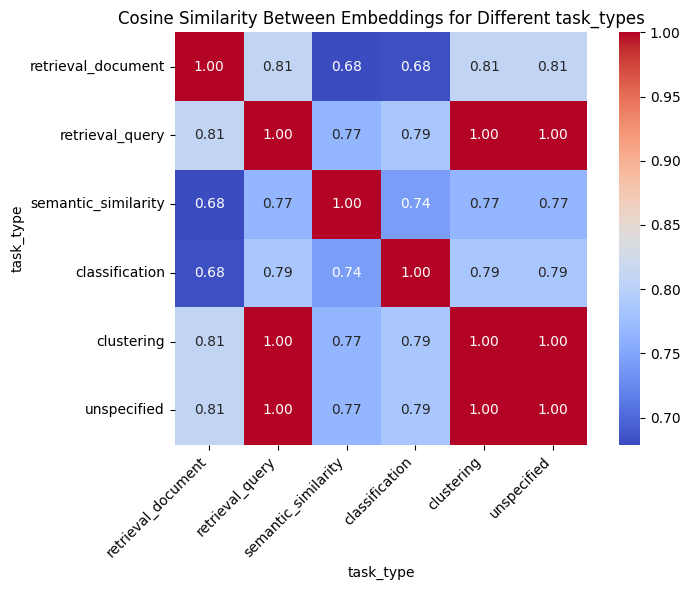

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Cosine Similarity Between Embeddings for Different task_types")
plt.xlabel("task_type")
plt.ylabel("task_type")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()